<a href="https://colab.research.google.com/github/sophiezla/FII-NX1Intl-SOPHIE-ZHU/blob/main/counterfeit_drug_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Counterfeit Drug Detection Project

Counterfeit drugs and falseified medicines create a huge risk towards public health. Drug counterfeiting has increased greatly in recent years, with counterfeits having made their way into the legal market.
They can be extremely harmful if taken- from contamination to under/over dosage which makes identifying and eliminating these drugs so important.

They particularly harm less-developed countries with less access to resources. As a part of the SDG goal 3, this project aims to be a tool in differentiating counterfeit and authentic medicine.

Information source
https://www.clientpharma.com/the-importance-of-detecting-counterfeit-medicines/


The dataset used in this project https://universe.roboflow.com/harshini-t-g-r/counterfeit_med_detection/dataset/4
includes images of counterfeit and authentic drugs, plus annotations

# Load Data

In [ ]:
#Load basic libraries for project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm import tqdm

from PIL import Image



Download the dataset from Roboflow

**!IMPORTANT!** To run this notebook you will need an API key from roboflow. API keys can be obtained for free: https://app.roboflow.com/login

In [ ]:
!pip install roboflow
#Install roboflow

from roboflow import Roboflow
from getpass import getpass
api_key = getpass("Enter your API key: ")
#Ask for API key
rf = Roboflow(api_key=api_key)
project = rf.workspace("harshini-t-g-r").project("counterfeit_med_detection")
#Access and download dataset
dataset = project.version(4).download("multiclass")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 110.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
Enter your API key: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Counterfeit_med_detection-4 in multiclass:: 100%|██████████| 4267/4267 [00:00<00:00, 5611.57it/s]


Dataset: Counterfeit_med_detection Computer Vision Dataset

Contains 1555 unique images (Total 4260 images)

Preprocessing applied already: auto-orientations. resizing all to 640x640.

Total dataset contains 4260 total images with augumentation.
Augementations include： 90 degree rotations clockwise and counter-clockwise, Exposure changes between -25% and +25%

Dataset is already presplit into test, train and validation. 4072 train set, 123 validation set, 65 test set.

In [ ]:
#Store each dataset
train_data = "/content/Counterfeit_med_detection-4/train"
val_data = "/content/Counterfeit_med_detection-4/valid"
test_data = "/content/Counterfeit_med_detection-4/test"

In [ ]:
#Explore dataset lengths
print(f'Length of train dataset: {len(os.listdir(train_data))}')
print(f'Length of validation dataset: {len(os.listdir(val_data))}')
print(f'Length of test dataset: {len(os.listdir(test_data))}')

Length of train dataset: 4073
Length of validation dataset: 123
Length of test dataset: 66


Additional item in train and test dataset appear to be an _classes.csv containing corresponding classes for each image

In [ ]:
# Load classes file
df = pd.read_csv("/content/Counterfeit_med_detection-4/train/_classes.csv")

# Look through first few rows
print(df.head())
#Look at column names
print(df.columns)

                                            filename   authentic   counterfeit
0  images4110_jpg.rf.a51e0991684677a14b9133060d82...           1             0
1  images239_jpg.rf.a540397ce79b45d1f9bb91b466281...           1             0
2  images342_jpg.rf.a4eb8f802f5a983da235655539bb2...           1             0
3  images349_jpg.rf.a45a8680d4a5970bba93346bad1ed...           1             0
4  images314_jpg.rf.a5086ebc5a1623d5efdbb3d7391d1...           1             0
Index(['filename', ' authentic', ' counterfeit'], dtype='object')


In [ ]:
#Define Transforms to tensor
#Resize to 264x264
Transform = transforms.Compose([transforms.Resize((264,264)), transforms.ToTensor()])

In [ ]:
#Check image and classes name match
img_dir = "/content/Counterfeit_med_detection-4/train"
print(os.listdir(img_dir)[:10])
csv_path = "/content/Counterfeit_med_detection-4/train/_classes.csv"
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()
print(df['filename'].head())

['FDA-Advisory-No-2022-0611-9_png.rf.86c39a9f6812c4cfb6902d63a0b51ddd.jpg', 'images5096_jpg.rf.c5eacbf9f96173d7840fa23dcc2e77c8.jpg', 'images235_jpg.rf.f8c8cc7e384a88b72e411c4f59fa6c90.jpg', 'images5064_jpg.rf.8f744992144f92869dee5c7c30bf87e3.jpg', 'images4044_jpg.rf.78a078dc53df3223cb340a540893b368.jpg', 'images268_jpg.rf.35c7793f867a087ca5a4c841b8abfae7.jpg', 'images5114_jpg.rf.7fbf91842bd235eaac40051f4f5186ef.jpg', '2020-1348_18_jpg.rf.48fec52816e895df84c54f475844f4d4.jpg', 'images07_jpg.rf.c764f90ebcc833d779c72afe457dc48b.jpg', 'images05_jpg.rf.12d13ac9d41a94601f28560a2dc3eff8.jpg']
0    images4110_jpg.rf.a51e0991684677a14b9133060d82...
1    images239_jpg.rf.a540397ce79b45d1f9bb91b466281...
2    images342_jpg.rf.a4eb8f802f5a983da235655539bb2...
3    images349_jpg.rf.a45a8680d4a5970bba93346bad1ed...
4    images314_jpg.rf.a5086ebc5a1623d5efdbb3d7391d1...
Name: filename, dtype: object


Design a class method to form the data into fully workable format

In [ ]:
class DrugDataset(Dataset):
    def __init__(self, img_dir, classes_csv, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        self.df = pd.read_csv(classes_csv)
        self.df.columns = self.df.columns.str.strip()

        #change labels
        self.df['label'] = self.df.apply(lambda row: 0 if row['authentic']==1 else 1, axis=1)
        #edit file path

        self.df['filepath'] = self.df['filename'].apply(lambda x: os.path.join(self.img_dir, x))


    def __len__(self):
    #method to return length
        return len(self.df)

    def __getitem__(self, idx):
      #method to retrieve item
        row = self.df.iloc[idx]
        image = Image.open(row['filepath']).convert("RGB")
        label = row['label']

        if self.transform:
            image = self.transform(image)

        return image, label


Transform and load each dataset into workable variables

In [ ]:

train_dataset = DrugDataset(
    img_dir="/content/Counterfeit_med_detection-4/train",
    classes_csv="/content/Counterfeit_med_detection-4/train/_classes.csv",
    transform=Transform
)

val_dataset = DrugDataset(
    img_dir="/content/Counterfeit_med_detection-4/valid",
    classes_csv="/content/Counterfeit_med_detection-4/valid/_classes.csv",
    transform=Transform
)

test_dataset = DrugDataset(
    img_dir="/content/Counterfeit_med_detection-4/test",
    classes_csv="/content/Counterfeit_med_detection-4/test/_classes.csv",
    transform=Transform
)

Visualize sample images from dataset

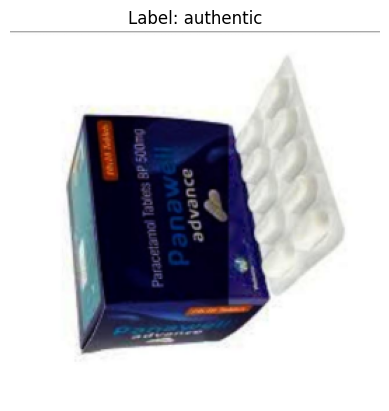

In [ ]:

image_num = 90 #@param {type:"raw"}
image, label = train_dataset[image_num]
image = image.permute(1, 2, 0).numpy()

#display image
plt.imshow(image)
#display label
plt.title(f"Label: {'authentic' if label==0 else 'counterfeit'}")
plt.axis('off')
plt.show()

# Model Building

In [ ]:
#set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Define model and layers

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=2): #default has 2 classes: authentic vs counterfeit
        super().__init__()
        #extract features
        self.conv_layers = nn.Sequential(
            #use 3 conv blocks
            nn.Conv2d(3, 16, kernel_size=3, padding=1), #3 RGB channel,
            nn.BatchNorm2d(16), #normalize batches
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), #downsample

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )

        #fully connect layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*33*33, 128),
            nn.ReLU(),
            nn.Dropout(0.5), #dropout to reduce overfitting
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

#set model
model = ConvNet().to(device)

In [ ]:
#get model summary
summary(model, (3, 264, 264))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 264, 264]             448
       BatchNorm2d-2         [-1, 16, 264, 264]              32
              ReLU-3         [-1, 16, 264, 264]               0
         MaxPool2d-4         [-1, 16, 132, 132]               0
            Conv2d-5         [-1, 32, 132, 132]           4,640
       BatchNorm2d-6         [-1, 32, 132, 132]              64
              ReLU-7         [-1, 32, 132, 132]               0
         MaxPool2d-8           [-1, 32, 66, 66]               0
            Conv2d-9           [-1, 64, 66, 66]          18,496
      BatchNorm2d-10           [-1, 64, 66, 66]             128
             ReLU-11           [-1, 64, 66, 66]               0
        MaxPool2d-12           [-1, 64, 33, 33]               0
          Flatten-13                [-1, 69696]               0
           Linear-14                  [

# Model Training and Evaluating

Create the dataloaders

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Create loss function and optimizer

In [ ]:
Weights = torch.tensor([1.0, (3952/120)**0.5], device=device) #make misclassification of counterfeits costlier
criterion = nn.CrossEntropyLoss(weight = Weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
batch = next(iter(train_dataloader))
print(type(batch))
print(len(batch))



<class 'list'>
2


Define train and validation loop

In [ ]:
def train_and_validate(model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs, device):
    model = model.to(device)
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []} #store metrics

    for epoch in range(epochs):

        model.train()
        running_loss, correct, total = 0, 0, 0
        for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad() #clear gradients
            outputs = model(images) #forward pass
            loss = loss_fn(outputs, labels)
            loss.backward() #backpropagation
            optimizer.step() #update weights

            running_loss += loss.item() * images.size(0) #update loss
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item() #count correct, total, etc.

        # calculate average loss for epoch
        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total


        #VALIDATION phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0


        with torch.no_grad():
            for images, labels in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        #calc average loss and accuracy
        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total

        #save all data metrics
        history["train_loss"].append(epoch_train_loss)
        history["train_acc"].append(epoch_train_acc)
        history["val_loss"].append(epoch_val_loss)
        history["val_acc"].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    return history


In [ ]:

train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, epochs=10, device=device)

Epoch 1/10 [Val]: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


Epoch 1/10 | Train Loss: 0.2872, Train Acc: 0.9786 | Val Loss: 1.9167, Val Acc: 0.9426


Epoch 2/10 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch 2/10 | Train Loss: 0.1399, Train Acc: 0.9821 | Val Loss: 1.2574, Val Acc: 0.9508


Epoch 3/10 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch 3/10 | Train Loss: 0.1069, Train Acc: 0.9860 | Val Loss: 1.5028, Val Acc: 0.9508


Epoch 4/10 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Epoch 4/10 | Train Loss: 0.1846, Train Acc: 0.9853 | Val Loss: 0.2687, Val Acc: 0.9262


Epoch 5/10 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Epoch 5/10 | Train Loss: 0.1191, Train Acc: 0.9835 | Val Loss: 0.6681, Val Acc: 0.9426


Epoch 6/10 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


Epoch 6/10 | Train Loss: 0.0716, Train Acc: 0.9845 | Val Loss: 0.9703, Val Acc: 0.9508


Epoch 7/10 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch 7/10 | Train Loss: 0.0519, Train Acc: 0.9872 | Val Loss: 0.9593, Val Acc: 0.9426


Epoch 8/10 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


Epoch 8/10 | Train Loss: 0.0497, Train Acc: 0.9867 | Val Loss: 1.0542, Val Acc: 0.9508


Epoch 9/10 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Epoch 9/10 | Train Loss: 0.0409, Train Acc: 0.9889 | Val Loss: 0.7953, Val Acc: 0.9180


Epoch 10/10 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s]

Epoch 10/10 | Train Loss: 0.0457, Train Acc: 0.9882 | Val Loss: 1.3780, Val Acc: 0.9508


{'train_loss': [0.28716741995849376,
  0.13991581268465852,
  0.10691936420778102,
  0.1846027790316269,
  0.1191143295327707,
  0.0715954234555532,
  0.051887057837572734,
  0.049703470755355666,
  0.040897726456173615,
  0.045718912884727035],
 'train_acc': [0.9786345776031434,
  0.9820726915520629,
  0.9860019646365422,
  0.9852652259332023,
  0.9835461689587426,
  0.9845284872298625,
  0.9872298624754421,
  0.9867387033398821,
  0.9889489194499018,
  0.9882121807465619],
 'val_loss': [1.9167455205174744,
  1.2573761266911951,
  1.5028492765440071,
  0.2687016570173418,
  0.668066845481574,
  0.9702607958776052,
  0.9593250405989954,
  1.0542128230826777,
  0.7952502705929725,
  1.3780488218867877],
 'val_acc': [0.9426229508196722,
  0.9508196721311475,
  0.9508196721311475,
  0.9262295081967213,
  0.9426229508196722,
  0.9508196721311475,
  0.9426229508196722,
  0.9508196721311475,
  0.9180327868852459,
  0.9508196721311475]}

#Model Testing

In [ ]:
#use testing metrics typical for CNN
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, roc_curve
)

In [ ]:
def test_loop(test_dataloader, model, loss_fn, device, class_names = None):
  model.eval()

  #storage for predictions, labels, etc.
  all_preds = []
  all_labels = []
  all_probs = []
  running_loss = 0.0

  with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            #pass in images
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            #calc loss and store
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * images.size(0)

            #store other results
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

  #calc average test loss and accuracy
  test_loss = running_loss / len(test_dataloader.dataset)
  test_acc = np.mean(np.array(all_preds) == np.array(all_labels))

  print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}\n")

  #Generate classification report
  print("Classification Report:")
  print(classification_report(all_labels, all_preds, target_names=class_names))

  #Generate confusion Matrix
  cm = confusion_matrix(all_labels, all_preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues, values_format='d')
  plt.title("Confusion Matrix")
  plt.show()

  #Generate ROC curve (binary classification)
  if len(set(all_labels)) == 2:
      auc = roc_auc_score(all_labels, np.array(all_probs)[:,1])
      fpr, tpr, _ = roc_curve(all_labels, np.array(all_probs)[:,1])
      print(f"ROC-AUC: {auc:.4f}")

      plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
      plt.plot([0,1], [0,1], linestyle="--")
      plt.xlabel("False Positive Rate")
      plt.ylabel("True Positive Rate")
      plt.title("ROC Curve")
      plt.legend()
      plt.show()

  return test_loss, test_acc, cm

Test Loss: 0.1578 | Test Accuracy: 0.9231

Classification Report:
              precision    recall  f1-score   support

   authentic       1.00      0.92      0.96        60
 counterfeit       0.50      1.00      0.67         5

    accuracy                           0.92        65
   macro avg       0.75      0.96      0.81        65
weighted avg       0.96      0.92      0.93        65



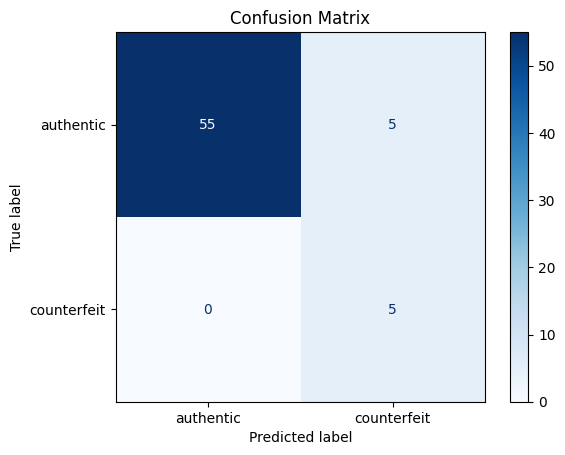

ROC-AUC: 0.9867


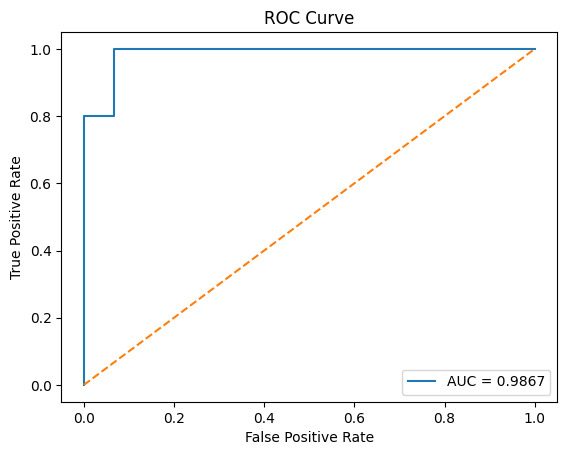

In [ ]:
test_loss, test_acc, cm = test_loop(test_dataloader, model, criterion, device, class_names=['authentic','counterfeit'])


# Final Implementation

Visualize images and model predictions

In [ ]:

idx_to_class = {0: "Authentic", 1: "Counterfeit"}

def visualize_prediction(model, dataset, device="cuda", index=None):
    model.eval()

    if index is None:
        index = torch.randint(0, len(dataset), (1,)).item()

    image, label = dataset[index]

    # Prepare image for model
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, pred = torch.max(outputs, 1)
        pred_class = idx_to_class[pred.item()]
        true_class = idx_to_class[label]

    # Show image
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"Predicted: {pred_class} | True: {true_class}")
    plt.show()


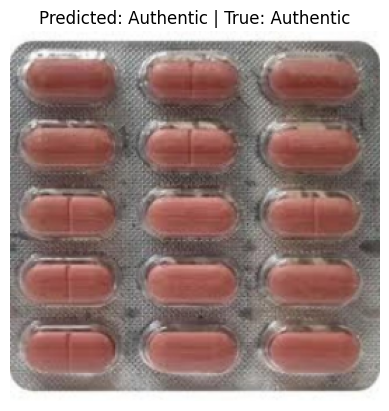

In [ ]:
visualize_prediction(model, test_dataset)


Allow user to upload own image files to input into model:



In [ ]:
from google.colab import files

In [ ]:
idx_to_class = {0: "Authentic", 1: "Counterfeit"}

def predict_and_plot_convnet(model, idx_to_class):

    #upload user image
    user_image = files.upload()
    image_path = list(user_image.keys())[0]

    #transform and load
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((264, 264)),
        transforms.ToTensor()
    ])
    user_tensor = transform(image).unsqueeze(0)

    #move all to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    user_tensor = user_tensor.to(device)

    # Predict
    model.eval()
    with torch.no_grad():
      output = model(user_tensor)
      pred_idx = output.argmax(dim=1).item()
      pred_class = idx_to_class[pred_idx]

    # Plot and show
    print("Predicted class:", pred_class)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {pred_class}")
    plt.show()



Saving editorial_new_method_for_combating.avif to editorial_new_method_for_combating.avif
Predicted class: Authentic


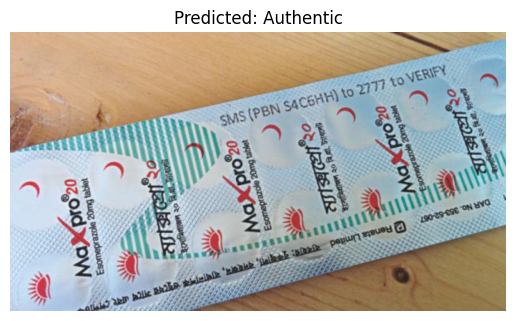

In [ ]:
predict_and_plot_convnet(model, idx_to_class)